In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [9]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [11]:
!kaggle datasets download -d aprabowo/indonesia-tourism-destination

100% 158k/158k [00:00<00:00, 640kB/s]
100% 158k/158k [00:00<00:00, 634kB/s]


In [12]:
!unzip \*.zip  && rm *.zip

Archive:  indonesia-tourism-destination.zip
  inflating: package_tourism.csv     
  inflating: tourism_rating.csv      
  inflating: tourism_with_id.csv     
  inflating: user.csv                


In [14]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

# Untuk visualisasi data
import plotly.express as px
from plotly.offline import iplot
import missingno as msno

# Untuk pembuatan sistem rekomendasi 
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

# Untuk evaluasi sistem rekomendasi
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score


# **Data Undestanding**

In [15]:
rating = pd.read_csv('/content/gdrive/MyDrive/Kaggle/tourism_rating.csv')
place = pd.read_csv('/content/gdrive/MyDrive/Kaggle/tourism_with_id.csv')
user = pd.read_csv('/content/gdrive/MyDrive/Kaggle/user.csv')

## **Univariate Exploratory Data Analysis**

In [16]:
print(f"The number of ratings given by the user to the dataset : {len(rating.User_Id)}")
print(f"Number of places in the datasets : {len(place.Place_Id.unique())}")
print(f"Number of users : {len(user.User_Id.unique())}")

The number of ratings given by the user to the dataset : 10000
Number of places in the datasets : 437
Number of users : 300


In [17]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   User_Id   300 non-null    int64 
 1   Location  300 non-null    object
 2   Age       300 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.2+ KB


In [18]:
rating.head()

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4


In [19]:
place.head()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Unnamed: 11,Unnamed: 12
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000,4.6,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392,106.827153,NaN,1
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0,4.6,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645,106.817125,NaN,2
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000,4.6,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312,106.833538,NaN,3
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000,4.5,NaN,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446,106.895156,NaN,4
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000,4.5,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190,106.839134,NaN,5


In [20]:
user.head()

,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
1,2,"Bekasi, Jawa Barat",21
2,3,"Cirebon, Jawa Barat",23
3,4,"Bekasi, Jawa Barat",21
4,5,"Lampung, Sumatera Selatan",20



# **Exploratory Data Analysis**



### **Place**

In [21]:
place.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 437 entries, 0 to 436
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Place_Id      437 non-null    int64  
 1   Place_Name    437 non-null    object 
 2   Description   437 non-null    object 
 3   Category      437 non-null    object 
 4   City          437 non-null    object 
 5   Price         437 non-null    int64  
 6   Rating        437 non-null    float64
 7   Time_Minutes  205 non-null    float64
 8   Coordinate    437 non-null    object 
 9   Lat           437 non-null    float64
 10  Long          437 non-null    float64
 11  Unnamed: 11   0 non-null      float64
 12  Unnamed: 12   437 non-null    int64  
dtypes: float64(5), int64(3), object(5)
memory usage: 44.5+ KB


In [22]:
place.Category.unique()

array(['Budaya', 'Taman Hiburan', 'Cagar Alam', 'Bahari',
       'Pusat Perbelanjaan', 'Tempat Ibadah'], dtype=object)

### **Rating**

In [23]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   User_Id        10000 non-null  int64
 1   Place_Id       10000 non-null  int64
 2   Place_Ratings  10000 non-null  int64
dtypes: int64(3)
memory usage: 234.5 KB


In [24]:
rating.head()

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4


In [25]:
rating.describe()

,User_Id,Place_Id,Place_Ratings
count,10000.000000,10000.000000,10000.000000
mean,151.292700,219.416400,3.066500
std,86.137374,126.228335,1.379952
min,1.000000,1.000000,1.000000
25%,77.000000,108.750000,2.000000
50%,151.000000,220.000000,3.000000
75%,226.000000,329.000000,4.000000
max,300.000000,437.000000,5.000000


In [30]:
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   User_Id   300 non-null    int64 
 1   Location  300 non-null    object
 2   Age       300 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 7.2+ KB


In [31]:
place.isnull().sum()

Place_Id          0
Place_Name        0
Description       0
Category          0
City              0
Price             0
Rating            0
Time_Minutes    232
Coordinate        0
Lat               0
Long              0
Unnamed: 11     437
Unnamed: 12       0
dtype: int64

In [32]:
rating.isnull().sum()

User_Id          0
Place_Id         0
Place_Ratings    0
dtype: int64

In [33]:
user.isnull().sum()

User_Id     0
Location    0
Age         0
dtype: int64

# **Data Prepocessing**

In [34]:
import numpy as np

tourism_all = np.concatenate((
    place.Place_Id.unique(),
    rating.Place_Id.unique()
))

tourism_all = np.sort(np.unique(tourism_all))

print(f"Total number of tourism: {len(tourism_all)}")

Total number of tourism: 437


In [35]:
all_tourism_rate = rating
all_tourism_rate

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4
...,...,...,...
9995,300,425,2
9996,300,64,4
9997,300,311,3
9998,300,279,4


In [36]:
all_tourism = pd.merge(all_tourism_rate,place[["Place_Id","Place_Name","Description","City","Category"]],on='Place_Id', how='left')
all_tourism

,User_Id,Place_Id,Place_Ratings,Place_Name,Description,City,Category
0,1,179,3,Candi Ratu Boko,Situs Ratu Baka atau Candi Boko (Hanacaraka:ꦕꦤ...,Yogyakarta,Budaya
1,1,344,2,Pantai Marina,"Pantai Marina (bahasa Jawa: ꦥꦱꦶꦱꦶꦂ​ꦩꦫꦶꦤ, trans...",Semarang,Bahari
2,1,5,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Jakarta,Taman Hiburan
3,1,373,3,Museum Kereta Ambarawa,Museum Kereta Api Ambarawa (bahasa Inggris: In...,Semarang,Budaya
4,1,101,4,Kampung Wisata Sosro Menduran,Kampung wisata Sosromenduran merupakan kampung...,Yogyakarta,Budaya
...,...,...,...,...,...,...,...
9995,300,425,2,Waterpark Kenjeran Surabaya,Waterpark Kenjeran Surabaya merupakan wisata k...,Surabaya,Taman Hiburan
9996,300,64,4,Museum Sasmita Loka Ahmad Yani,Museum Sasmita Loka Ahmad Yani adalah salah sa...,Jakarta,Budaya
9997,300,311,3,The Lodge Maribaya,The Lodge Maribaya adalah salah satu tempat wi...,Bandung,Cagar Alam
9998,300,279,4,Masjid Agung Trans Studio Bandung,Masjid Agung Trans Studio Bandung (TSB) berdir...,Bandung,Tempat Ibadah


In [37]:
all_tourism['city_category'] = all_tourism[['City','Category']].agg(' '.join,axis=1)
all_tourism

,User_Id,Place_Id,Place_Ratings,Place_Name,Description,City,Category,city_category
0,1,179,3,Candi Ratu Boko,Situs Ratu Baka atau Candi Boko (Hanacaraka:ꦕꦤ...,Yogyakarta,Budaya,Yogyakarta Budaya
1,1,344,2,Pantai Marina,"Pantai Marina (bahasa Jawa: ꦥꦱꦶꦱꦶꦂ​ꦩꦫꦶꦤ, trans...",Semarang,Bahari,Semarang Bahari
2,1,5,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Jakarta,Taman Hiburan,Jakarta Taman Hiburan
3,1,373,3,Museum Kereta Ambarawa,Museum Kereta Api Ambarawa (bahasa Inggris: In...,Semarang,Budaya,Semarang Budaya
4,1,101,4,Kampung Wisata Sosro Menduran,Kampung wisata Sosromenduran merupakan kampung...,Yogyakarta,Budaya,Yogyakarta Budaya
...,...,...,...,...,...,...,...,...
9995,300,425,2,Waterpark Kenjeran Surabaya,Waterpark Kenjeran Surabaya merupakan wisata k...,Surabaya,Taman Hiburan,Surabaya Taman Hiburan
9996,300,64,4,Museum Sasmita Loka Ahmad Yani,Museum Sasmita Loka Ahmad Yani adalah salah sa...,Jakarta,Budaya,Jakarta Budaya
9997,300,311,3,The Lodge Maribaya,The Lodge Maribaya adalah salah satu tempat wi...,Bandung,Cagar Alam,Bandung Cagar Alam
9998,300,279,4,Masjid Agung Trans Studio Bandung,Masjid Agung Trans Studio Bandung (TSB) berdir...,Bandung,Tempat Ibadah,Bandung Tempat Ibadah


# **Data Preparation**

Missing Value

In [38]:
all_tourism.isnull().sum()

User_Id          0
Place_Id         0
Place_Ratings    0
Place_Name       0
Description      0
City             0
Category         0
city_category    0
dtype: int64

In [39]:
preparation= all_tourism.drop_duplicates("Place_Id")
preparation

,User_Id,Place_Id,Place_Ratings,Place_Name,Description,City,Category,city_category
0,1,179,3,Candi Ratu Boko,Situs Ratu Baka atau Candi Boko (Hanacaraka:ꦕꦤ...,Yogyakarta,Budaya,Yogyakarta Budaya
1,1,344,2,Pantai Marina,"Pantai Marina (bahasa Jawa: ꦥꦱꦶꦱꦶꦂ​ꦩꦫꦶꦤ, trans...",Semarang,Bahari,Semarang Bahari
2,1,5,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Jakarta,Taman Hiburan,Jakarta Taman Hiburan
3,1,373,3,Museum Kereta Ambarawa,Museum Kereta Api Ambarawa (bahasa Inggris: In...,Semarang,Budaya,Semarang Budaya
4,1,101,4,Kampung Wisata Sosro Menduran,Kampung wisata Sosromenduran merupakan kampung...,Yogyakarta,Budaya,Yogyakarta Budaya
...,...,...,...,...,...,...,...,...
2008,62,370,1,Benteng Pendem,Benteng Pendem Cilacap (bahasa Belanda: Kustba...,Semarang,Budaya,Semarang Budaya
2399,74,350,4,Pantai Cipta,Pantai Cipta juga dikenal sebagai Pantai Petik...,Semarang,Bahari,Semarang Bahari
2448,75,10,2,Pulau Tidung,Pulau Tidung adalah salah satu kelurahan di ke...,Jakarta,Bahari,Jakarta Bahari
2534,78,7,4,Kebun Binatang Ragunan,Kebun Binatang Ragunan adalah sebuah kebun bin...,Jakarta,Cagar Alam,Jakarta Cagar Alam


In [40]:
place_id = preparation.Place_Id.tolist()

place_name = preparation.Place_Name.tolist()

place_category = preparation.Category.tolist()

place_desc = preparation.Description.tolist()

place_city = preparation.City.tolist()

city_category = preparation.city_category.tolist()

In [41]:
tourism_new = pd.DataFrame({
    "id":place_id,
    "name":place_name,
    "category":place_category,
    "description":place_desc,
    "city":place_city,
    "city_category":city_category
})

tourism_new

,id,name,category,description,city,city_category
0,179,Candi Ratu Boko,Budaya,Situs Ratu Baka atau Candi Boko (Hanacaraka:ꦕꦤ...,Yogyakarta,Yogyakarta Budaya
1,344,Pantai Marina,Bahari,"Pantai Marina (bahasa Jawa: ꦥꦱꦶꦱꦶꦂ​ꦩꦫꦶꦤ, trans...",Semarang,Semarang Bahari
2,5,Atlantis Water Adventure,Taman Hiburan,Atlantis Water Adventure atau dikenal dengan A...,Jakarta,Jakarta Taman Hiburan
3,373,Museum Kereta Ambarawa,Budaya,Museum Kereta Api Ambarawa (bahasa Inggris: In...,Semarang,Semarang Budaya
4,101,Kampung Wisata Sosro Menduran,Budaya,Kampung wisata Sosromenduran merupakan kampung...,Yogyakarta,Yogyakarta Budaya
...,...,...,...,...,...,...
432,370,Benteng Pendem,Budaya,Benteng Pendem Cilacap (bahasa Belanda: Kustba...,Semarang,Semarang Budaya
433,350,Pantai Cipta,Bahari,Pantai Cipta juga dikenal sebagai Pantai Petik...,Semarang,Semarang Bahari
434,10,Pulau Tidung,Bahari,Pulau Tidung adalah salah satu kelurahan di ke...,Jakarta,Jakarta Bahari
435,7,Kebun Binatang Ragunan,Cagar Alam,Kebun Binatang Ragunan adalah sebuah kebun bin...,Jakarta,Jakarta Cagar Alam


Content Based Filtering

In [42]:
data = tourism_new
data.sample(5)

,id,name,category,description,city,city_category
408,218,Kawah Putih,Cagar Alam,Kawah Putih adalah sebuah tempat wisata di Jaw...,Bandung,Bandung Cagar Alam
413,351,Old City 3D Trick Art Museum,Budaya,Destinasi wisata kekinian satu ini memang teng...,Semarang,Semarang Budaya
305,84,Kawasan Kuliner BSM,Pusat Perbelanjaan,"Tidak seperti Pecenongan, Kawasan Kuliner BSM ...",Jakarta,Jakarta Pusat Perbelanjaan
250,8,Ocean Ecopark,Taman Hiburan,Ocean Ecopark Salah satu zona rekreasi Ancol y...,Jakarta,Jakarta Taman Hiburan
34,371,Wisata Eling Bening,Cagar Alam,Sebuah fasilitas wisata yang dikelola dengan c...,Semarang,Semarang Cagar Alam


In [43]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()

cv.fit(data['city_category'])

print("Features Name: ", list(cv.vocabulary_.keys()))

Features Name:  ['yogyakarta', 'budaya', 'semarang', 'bahari', 'jakarta', 'taman', 'hiburan', 'bandung', 'cagar', 'alam', 'surabaya', 'pusat', 'perbelanjaan', 'tempat', 'ibadah']


In [44]:
cv_matrix = cv.transform(data['city_category']) 
 
cv_matrix.shape 

(437, 15)

In [45]:
cv_matrix.todense()

matrix([[0, 0, 0, ..., 0, 0, 1],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        ...,
        [0, 1, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 1]])

In [46]:
pd.DataFrame(
    cv_matrix.todense(),
    columns=list(cv.vocabulary_.keys()),
    index = data.name
).sample(5)

,yogyakarta,budaya,semarang,bahari,jakarta,taman,hiburan,bandung,cagar,alam,surabaya,pusat,perbelanjaan,tempat,ibadah
name,,,,,,,,,,,,,,,
Gereja Perawan Maria Tak Berdosa Surabaya,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0
Candi Ratu Boko,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
Balai Kota Surabaya,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
Pasar Kebon Empring Bintaran,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1
Alun-alun Utara Keraton Yogyakarta,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [47]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(cv_matrix)
cosine_sim

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.40824829],
       [0.        , 1.        , 0.        , ..., 0.5       , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.40824829, 0.33333333,
        0.66666667],
       ...,
       [0.        , 0.5       , 0.40824829, ..., 1.        , 0.40824829,
        0.        ],
       [0.        , 0.        , 0.33333333, ..., 0.40824829, 1.        ,
        0.        ],
       [0.40824829, 0.        , 0.66666667, ..., 0.        , 0.        ,
        1.        ]])

In [48]:
cosine_sim_df = pd.DataFrame(cosine_sim,index=data['name'],columns=data['name'])
cosine_sim_df.sample(5,axis=1).sample(10,axis=0)

name,Kampung Wisata Kadipaten,Jogja Exotarium,Pantai Pok Tunggal,Kampung Korea Bandung,Museum Taman Prasasti
name,,,,,
Kidzania,0.000000,0.666667,0.000000,0.000000,0.408248
Kiara Artha Park,0.000000,0.666667,0.000000,0.408248,0.000000
Taman Situ Lembang,0.000000,0.666667,0.000000,0.000000,0.408248
Monumen Bandung Lautan Api,0.500000,0.000000,0.000000,1.000000,0.500000
NuArt Sculpture Park,0.000000,0.666667,0.000000,0.408248,0.000000
Museum Gunung Merapi,1.000000,0.408248,0.500000,0.500000,0.500000
Taman Hutan Raya Ir. H. Juanda,0.000000,0.000000,0.000000,0.408248,0.000000
Embung Tambakboyo,0.408248,1.000000,0.408248,0.000000,0.000000
Pantai Sepanjang,0.500000,0.408248,1.000000,0.000000,0.000000


In [49]:
def tourism_recommendations(place_name,similarity_data=cosine_sim_df,items=data[['name','category','description','city']],k=5):
    index = similarity_data.loc[:,place_name].to_numpy().argpartition(range(-1,-k,-1))
    
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    
    closest = closest.drop(place_name,errors='ignore')
    
    return pd.DataFrame(closest).merge(items).head(k)

In [50]:
tourism_recommendations("Air Mancur Menari")

,name,category,description,city
0,Taman Prestasi,Taman Hiburan,Taman Prestasi Surabaya merupakan salah satu t...,Surabaya
1,Taman Pelangi,Taman Hiburan,Kalau pelangi biasanya ada di siang hari pasca...,Surabaya
2,Atlantis Land Surabaya,Taman Hiburan,"Sejak diresmikan pada bulan Desember 2017, Atl...",Surabaya
3,Taman Buah Surabaya,Taman Hiburan,Wisata Taman Buah Undaan di Surabaya adalah sa...,Surabaya
4,Taman Keputran,Taman Hiburan,"Ntah, mengapa nama taman ini disebut dengan ta...",Surabaya


In [51]:
tourism_recommendations("Trans Studio Bandung")

,name,category,description,city
0,Puspa Iptek Sundial,Taman Hiburan,Puspa Iptek Sundial adalah wahana pendidikan y...,Bandung
1,Teras Cikapundung BBWS,Taman Hiburan,Teras Cikapundung Bandung sebelumnya merupakan...,Bandung
2,Chingu Cafe Little Seoul,Taman Hiburan,Selain populer karena memiliki pemandangan yan...,Bandung
3,Taman Badak,Taman Hiburan,Taman Badak ini baru saja diresmikan pada tang...,Bandung
4,NuArt Sculpture Park,Taman Hiburan,NuArt Sculpture Park ini merupakan sebuah gall...,Bandung


In [52]:
import pandas as pd
import numpy as np 
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

In [53]:
df = rating
df

,User_Id,Place_Id,Place_Ratings
0,1,179,3
1,1,344,2
2,1,5,5
3,1,373,3
4,1,101,4
...,...,...,...
9995,300,425,2
9996,300,64,4
9997,300,311,3
9998,300,279,4


In [54]:
user_ids = df.User_Id.unique().tolist()

user_to_user_encoded = {x:i for i, x in enumerate(user_ids)}

user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}

In [55]:
place_ids = df.Place_Id.unique().tolist()

place_to_place_encoded = {x: i for i, x in enumerate(place_ids)}

place_encoded_to_place = {x: i for x, i in enumerate(place_ids)}

In [56]:
df['user'] = df.User_Id.map(user_to_user_encoded)

df['place'] = df.Place_Id.map(place_to_place_encoded)

In [57]:
num_users = len(user_to_user_encoded)

num_place = len(place_encoded_to_place)

df['Place_Ratings'] = df['Place_Ratings'].values.astype(np.float32)

min_rating = min(df['Place_Ratings'])

max_rating= max(df['Place_Ratings'])

print('Number of User: {}, Number of Place: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_place, min_rating, max_rating
))

Number of User: 300, Number of Place: 437, Min Rating: 1.0, Max Rating: 5.0


In [58]:
df = df.sample(frac=1,random_state=42)
df

,User_Id,Place_Id,Place_Ratings,user,place
6252,188,207,3.0,187,262
4684,142,268,2.0,141,83
1731,54,103,3.0,53,10
4742,144,119,3.0,143,141
4521,138,288,5.0,137,283
...,...,...,...,...,...
5734,173,402,5.0,172,175
5191,157,85,4.0,156,33
5390,163,18,3.0,162,52
860,28,416,4.0,27,187


In [59]:
x = df[['user','place']].values

y = df['Place_Ratings'].apply(lambda x:(x-min_rating)/(max_rating-min_rating)).values

train_indices = int(0.8 * df.shape[0])

x_train,x_val,y_train,y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x,y)

[[187 262]
 [141  83]
 [ 53  10]
 ...
 [162  52]
 [ 27 187]
 [218   6]] [0.5  0.25 0.5  ... 0.5  0.75 0.25]


In [60]:
class RecommenderNet(tf.keras.Model):
 
  # Insialisasi fungsi
  def __init__(self, num_users, num_place, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_place = num_place
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) 
    self.place_embedding = layers.Embedding( 
        num_place,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.place_bias = layers.Embedding(num_place, 1) 
 
  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    place_vector = self.place_embedding(inputs[:, 1]) # memanggil layer embedding 3
    place_bias = self.place_bias(inputs[:, 1]) # memanggil layer embedding 4
 
    dot_user_place = tf.tensordot(user_vector, place_vector, 2) 
 
    x = dot_user_place + user_bias + place_bias
    
    return tf.nn.sigmoid(x) # activation sigmoid

In [61]:
model = RecommenderNet(num_users, num_place, 100)
 
# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [62]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 8,
    epochs = 100,
    validation_data = (x_val, y_val),
)

Epoch 1/100
1000/1000 [==============================] - 6s 5ms/step - loss: 0.6956 - root_mean_squared_error: 0.3469 - val_loss: 0.6956 - val_root_mean_squared_error: 0.3466
Epoch 2/100
1000/1000 [==============================] - 5s 5ms/step - loss: 0.6893 - root_mean_squared_error: 0.3424 - val_loss: 0.6957 - val_root_mean_squared_error: 0.3466
Epoch 3/100
1000/1000 [==============================] - 3s 3ms/step - loss: 0.6842 - root_mean_squared_error: 0.3387 - val_loss: 0.6964 - val_root_mean_squared_error: 0.3471
Epoch 4/100
1000/1000 [==============================] - 4s 4ms/step - loss: 0.6773 - root_mean_squared_error: 0.3336 - val_loss: 0.6972 - val_root_mean_squared_error: 0.3476
Epoch 5/100
1000/1000 [==============================] - 5s 5ms/step - loss: 0.6767 - root_mean_squared_error: 0.3331 - val_loss: 0.6972 - val_root_mean_squared_error: 0.3476
Epoch 6/100
1000/1000 [==============================] - 4s 4ms/step - loss: 0.6708 - root_mean_squared_error: 0.3287 - val_l

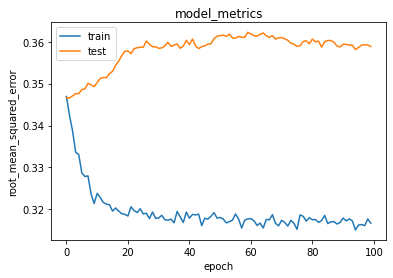

In [63]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [64]:
place_df = tourism_new
df = pd.read_csv(f'/content/gdrive/MyDrive/Kaggle/tourism_rating.csv')

user_id = df.User_Id.sample(1).iloc[0]
place_visited_by_user = df[df.User_Id == user_id]

place_not_visited = place_df[~place_df['id'].isin(place_visited_by_user['Place_Id'].values)]['id'] 
place_not_visited = list(
    set(place_not_visited)
    .intersection(set(place_to_place_encoded.keys()))
)
 
place_not_visited = [[place_to_place_encoded.get(x)] for x in place_not_visited]
user_encoder = user_to_user_encoded.get(user_id)
user_place_array = np.hstack(
    ([[user_encoder]] * len(place_not_visited), place_not_visited)
)

In [65]:
ratings = model.predict(user_place_array).flatten()
 
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_place_ids = [
    place_encoded_to_place.get(place_not_visited[x][0]) for x in top_ratings_indices
]
 
print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('Place with high ratings from user')
print('----' * 8)
 
top_place_user = (
    place_visited_by_user.sort_values(
        by = 'Place_Ratings',
        ascending=False
    )
    .head(5)
    .Place_Id.values
)
 
place_df_rows = place_df[place_df['id'].isin(top_place_user)]
pd.DataFrame(place_df_rows)

13/13 [==============================] - 0s 2ms/step
Showing recommendations for users: 240
Place with high ratings from user
--------------------------------


,id,name,category,description,city,city_category
177,417,Klenteng Sanggar Agung,Budaya,Kelenteng Sanggar Agung atau Klenteng Hong San...,Surabaya,Surabaya Budaya
188,378,Jembatan Biru Ambarawa,Taman Hiburan,"Jembatan ini terletak di Tuntang, Kab. Semaran...",Semarang,Semarang Taman Hiburan
385,282,Curug Cilengkrang,Cagar Alam,Curug Cilengkrang bisa menjadi pilihan tujuan ...,Bandung,Bandung Cagar Alam
390,39,Museum Macan (Modern and Contemporary Art in N...,Budaya,Museum Seni Modern dan Kontemporer di Nusantar...,Jakarta,Jakarta Budaya
428,51,Jakarta Planetarium,Taman Hiburan,Planetarium dan Observatorium Jakarta adalah s...,Jakarta,Jakarta Taman Hiburan


In [66]:
print('----' * 8)
print('Top 10 place recommendation')
print('----' * 8)
 
recommended_place = place_df[place_df['id'].isin(recommended_place_ids)]
recommended_place

--------------------------------
Top 10 place recommendation
--------------------------------


,id,name,category,description,city,city_category
71,382,Kampoeng Kopi Banaran,Taman Hiburan,"Kampoeng Kopi Banaran, sebuah agro wisata perk...",Semarang,Semarang Taman Hiburan
90,377,La Kana Chapel,Taman Hiburan,La Kana Chapel menawarkan konsep baru standing...,Semarang,Semarang Taman Hiburan
120,346,Indonesia Kaya Park,Taman Hiburan,Lokasi Taman Indonesia Kaya yang berada di pus...,Semarang,Semarang Taman Hiburan
137,359,Taman Bunga Celosia,Cagar Alam,Wisata Semarang menawarkan berbagai tempat wis...,Semarang,Semarang Cagar Alam
145,379,Goa Rong,Cagar Alam,Semarang memiliki wisata di ketinggian bernama...,Semarang,Semarang Cagar Alam
346,372,Gua Maria Kerep Ambarawa,Cagar Alam,"Gua Maria Kerep (Gua Maria Kerep Ambarawa, dis...",Semarang,Semarang Cagar Alam
356,352,GPIB Immanuel Semarang (Gereja Blenduk),Tempat Ibadah,GPIB Immanuel Semarang (populer dengan nama Ge...,Semarang,Semarang Tempat Ibadah
371,358,Masjid Kapal Semarang,Tempat Ibadah,Masjid Safinatun Najah atau pengunjung biasa m...,Semarang,Semarang Tempat Ibadah
372,353,Taman Srigunting,Taman Hiburan,Merupakan salah satu landmark di Kawasan Kota ...,Semarang,Semarang Taman Hiburan
389,345,Kampoeng Djadhoel Semarang,Budaya,Kampoeng Djadhoel terletak di Kampung Batik Se...,Semarang,Semarang Budaya
